In [1]:
# finetuning llama2

In [2]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [3]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline

device_map="cuda:1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

full_lora_layers = [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]


def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#init model

model_size=7
r=32
lora_alpha=32
bit=16
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]
#target_modules=[]
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"


#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


Using fp16 mode


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [60]:

pipe = pipeline("text-generation", model=model,
                tokenizer=tokenizer, max_new_tokens=1000)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [61]:
import pandas as pd
df=pd.read_csv("dataset/231225AutoReasoning/24102best_reason_record.csv")
dataset=df.to_dict(orient="records")
df[:2]

,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,(-)-2-amino-3-phenyl-1-propanol,NC(Cc1ccccc1)CO,69116,http://www.amazon.com/dp/B003XEQTLE,Aldrich Chemical Company; Aldrich Catalog-Hand...,The compound (-)-2-amino-3-phenyl-1-propanol h...,92.0,92.0,0.0
1,(3Z)-5-Isobutyl-3-[(5-phenyl-2-furyl)methylene...,O=C1OC(=CC1=Cc1oc(cc1)c1ccccc1)CC(C)C,1474618,http://dx.doi.org/10.1021/ci0500132,Karthikeyan M.; Glen R.C.; Bender A. General m...,To predict the melting point of (3Z)-5-Isobuty...,76.0,76.0,0.0


In [62]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction="",prefix="Example"):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#{prefix} Data
##Name: {name}
##SMILES: {smiles} 
##Reason: {reason}
##Prediction: {prediction}
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id],prefix="Test")
#    prompt+="""
##Output: Reason, Prediction
#    """

    return prompt

In [63]:
#fineturning
from datasets import Dataset


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [64]:

#とりあえず初めの10件をテストデータにする
n_test=10

train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/546 [00:00<?, ? examples/s]

Map: 100%|██████████| 546/546 [00:00<00:00, 7328.05 examples/s]


In [65]:
import transformers
from datetime import datetime

gradient_checkpointing = False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

In [66]:

import re
def ask_value(prompt,pipe):
    res=pipe(prompt)[0]["generated_text"]
    res=res[len(prompt):]

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Predicted melting point:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value
    

In [67]:
import copy
prediction_results={}

for n_prompt_examples in [3]:
    res_list=[]
    for test_id in range(n_test):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,pipe)
            record=copy.deepcopy(dataset[test_id])

            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
        except Exception as e:
            print(e)
            continue

    prediction_results[n_prompt_examples]=res_list

actual:  92.0 predicted:  225.0
actual:  76.0 predicted:  None
actual:  311.0 predicted:  140.0
actual:  178.0 predicted:  None
actual:  83.85 predicted:  62.0
actual:  73.5 predicted:  None
actual:  42.0 predicted:  285.0
actual:  260.0 predicted:  140.0
actual:  230.0 predicted:  None
actual:  105.0 predicted:  None


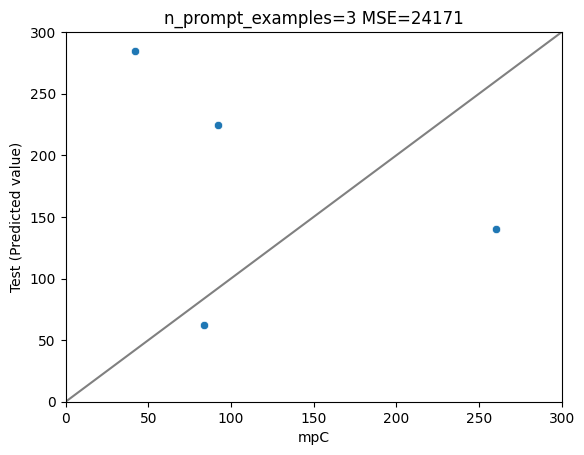

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

vmin=0
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    plt.savefig(f"results/llama{model_size}_n_prompt_examples={n_prompt_examples}_train={do_train}.png")
    #break

In [71]:
print(prompt)


#Example Data
##Name: (2E)-6-methoxy-8-methyl-2-(phenylmethylidene)-3,4-dihydronaphthalen-1(2H)-one
##SMILES: O=C1C(=Cc2ccccc2)CCc2cc(OC)cc(C)c21 
##Reason: The compound in question is a modified naphthalene structure with additional functional groups that influence its melting point: an ester (ketone), a phenyl, a methoxy, and a methyl group. Starting with naphthalene's base melting point of about 80°C, we consider the effects of the functional groups: The ester (ketone) group, while capable of leading to polar interactions, only provides acceptor sites for hydrogen bonding and thus might add around +10°C instead of the speculated +20°C. The phenyl group increases rigidity and molecular mass, contributing +10°C rather than the speculated +15°C. The methoxy group increases polarizability and slightly molecular size; thus, a more modest increase of +3°C is expected instead of +5°C. The methyl group increases hydrophobic character marginally, contributing around +1°C rather than +2°C. T